# STOCK PRICE PREDICTION OF GOOGLE DATA USING GRU MODEL 

In [308]:
#Import libraries

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import math
import string
import pandas as pd 
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.metrics import mean_squared_error


In [309]:
drive.mount('/content/drive')
!ls '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path_results = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Results/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AMAZON.csv  DownloadData.ipynb	GOOGLE.csv


## LOAD AND VISUALIZE DATA

In [310]:
#Read Google dataset 
raw_data = pd.read_csv(path+'GOOGLE.csv', parse_dates=True, index_col=0)
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031925
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987226
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876685
2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9484016


In [311]:
raw_data.info() #not null data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [312]:
raw_data['Close'].describe()

count    2516.000000
mean      643.921354
std       325.706384
min       217.220810
25%       316.365440
50%       562.994751
75%       929.412491
max      1361.170044
Name: Close, dtype: float64

We collected the data for 10 years (from 01 January 2010 to 01 January 2020) and have 2516 instances in the dataset. We can observe that there is non-null values in our dataset and the most of the feature are float except Volume that is an integer and the date that is an object. We will explain the meaining of the features of the dataset:


*   Date: It is the date of the observation
*   Open: Raw stock values when the market opened.
*   High: Highest stock value in that date.
*   Low: Lowest stock value in that date.
*   Close: Raw stock values when the market closed.
*   Adj Close: Estimated stock values after the market closes.
*   Volume: Number of shares traded. 

We are going to work with the stock values when the market closed, the feature *Close*.


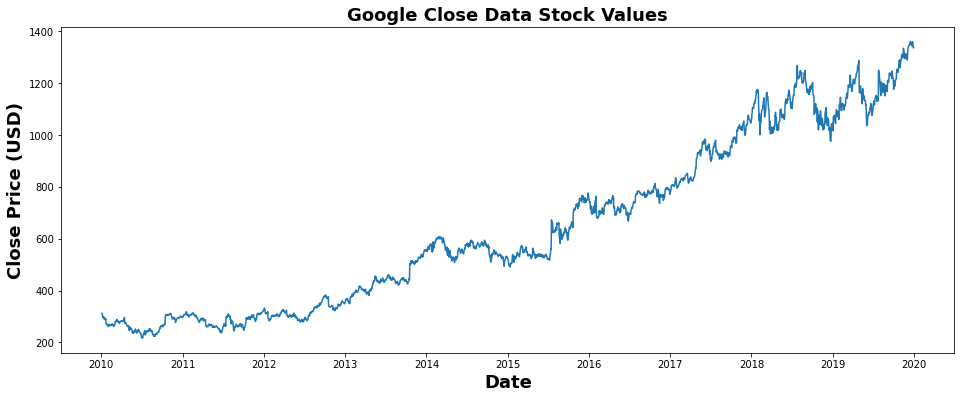

In [313]:
#Visualize the close price
plt.figure(figsize = (16,6))
plt.title('Google Close Data Stock Values', fontsize = 18,fontweight = "bold")
plt.plot(raw_data['Close'])
plt.xlabel("Date" , fontsize = 18,fontweight = "bold")
plt.ylabel("Close Price (USD)", fontsize = 18,fontweight = "bold")

plt.show()

<function matplotlib.pyplot.show>

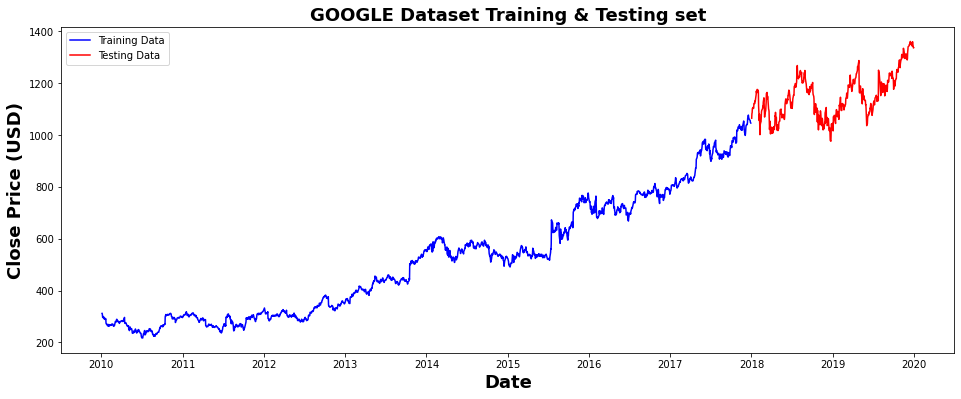

In [314]:
#Visualize the train and test set 
traininig_size = round(raw_data.shape[0]*0.8)
training = raw_data.iloc[:traininig_size,:]
testing = raw_data.iloc[traininig_size:,:]

plt.figure(figsize = (16,6))
ax = plt.axes()
plt.title('GOOGLE Dataset Training & Testing set', fontsize = 18,fontweight = "bold")
plt.xlabel('Date' , fontsize = 18,fontweight = "bold")
plt.ylabel('Close Price (USD)', fontsize = 18,fontweight = "bold")
plt.plot(training['Close'], 'blue', label='Training Data')
plt.plot(testing['Close'], 'red', label='Testing Data')
plt.legend()
plt.show

## NORMALIZE AND SPLIT DATA INTO TRAIN AND TEST DATASET

In [315]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# we work only with close values
df_google = raw_data.filter(items=['Close'])

#Normalize data between -1 and 1 
df_google["Close"]= scaler.fit_transform(df_google["Close"].values.reshape(-1,1))

df_google

,Close
Date,
2010-01-04,-0.833937
2010-01-05,-0.836340
2010-01-06,-0.850040
2010-01-07,-0.862372
2010-01-08,-0.855474
...,...
2019-12-24,0.969212
2019-12-26,0.998654
2019-12-27,0.983775


In [316]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    x = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        x.append(data_raw[index : index + look_back])
    
    x = np.array(x)  

    test_set_size = int(np.round(0.2*x.shape[0]))
    train_set_size = x.shape[0] - (test_set_size)

    #Create new data set
    x_train = x[:train_set_size,:-1]
    y_train = x[:train_set_size,-1]

    x_test = x[train_set_size:,:-1]
    y_test = x[train_set_size:,-1]

    
    return [x_train, y_train, x_test, y_test]


look_back = 30 #Choose sequence length


x_train, y_train, x_test, y_test = load_data(df_google, look_back)


print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1989, 29, 1)
y_train.shape =  (1989, 1)
x_test.shape =  (497, 29, 1)
y_test.shape =  (497, 1)


In [317]:
#Convert dataset from numpy to tensor 
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


## Create the GRU model 

In [318]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out_gru, (hn) = self.gru(x, h0.detach())
        out = self.fc(out_gru[:,-1,:])
        return out
    

We define the model, loss function and hyperparameters

In [319]:
#parameters
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs =100

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.MSELoss()  #Mean Square Error loss function

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam optimizer

## Train and Testing

Epoch  0 MSE:  0.3568165600299835
Epoch  1 MSE:  0.12537893652915955
Epoch  2 MSE:  0.10760891437530518
Epoch  3 MSE:  0.07579761743545532
Epoch  4 MSE:  0.04224129393696785
Epoch  5 MSE:  0.019275030121207237
Epoch  6 MSE:  0.004041262436658144
Epoch  7 MSE:  0.03112182952463627
Epoch  8 MSE:  0.012770422734320164
Epoch  9 MSE:  0.014225459657609463
Epoch  10 MSE:  0.0015626581152901053
Epoch  11 MSE:  0.005116569809615612
Epoch  12 MSE:  0.010243004187941551
Epoch  13 MSE:  0.007678660564124584
Epoch  14 MSE:  0.008025177754461765
Epoch  15 MSE:  0.009707720950245857
Epoch  16 MSE:  0.005132786463946104
Epoch  17 MSE:  0.0026868507266044617
Epoch  18 MSE:  0.0032974709756672382
Epoch  19 MSE:  0.0016901640919968486
Epoch  20 MSE:  0.0007930867723189294
Epoch  21 MSE:  0.003451310098171234
Epoch  22 MSE:  0.00340257422067225
Epoch  23 MSE:  0.002464507706463337
Epoch  24 MSE:  0.0031796416733413935
Epoch  25 MSE:  0.0021452573128044605
Epoch  26 MSE:  0.000592742464505136
Epoch  27 MS

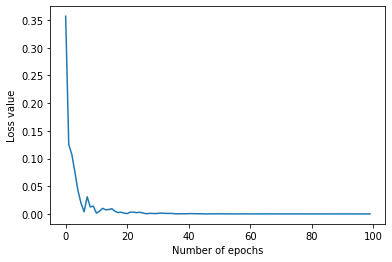

In [320]:
#Trainig the model 
loss_gru = []
model.train() #active train mode
for iter in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", iter, "MSE: ", loss.item())

    loss_gru.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_gru)
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.show()

Text(0, 0.5, 'Close Price (USD)')

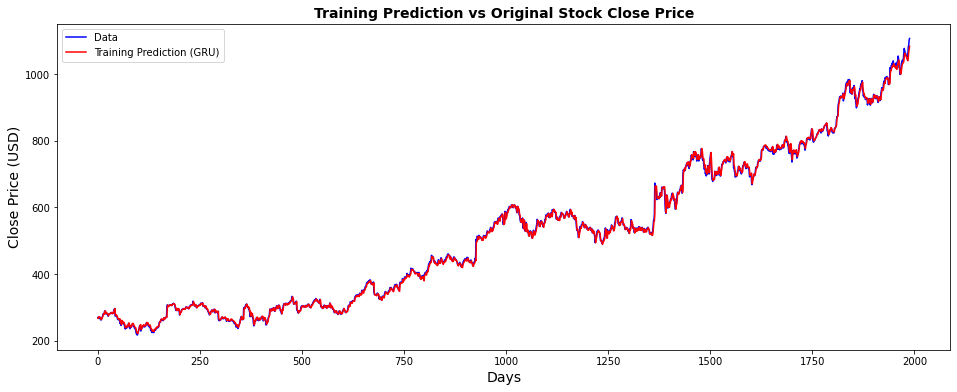

In [321]:
#Visualize the training predictions

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

plt.figure(figsize = (16,6))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='red')
ax.set_title('Training Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)

In [322]:
#Testing the model 

# make predictions
model.eval()
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

Text(0, 0.5, 'Close Price (USD)')

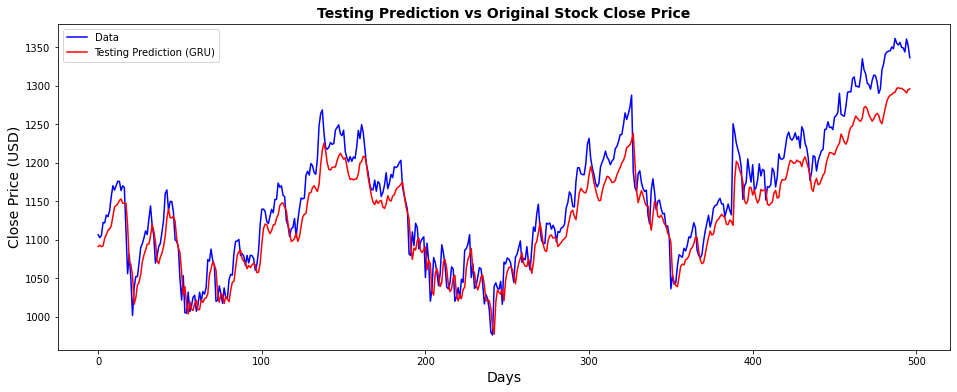

In [323]:
#Visualize the testing predictions
original =  pd.DataFrame(y_test)
predict =  pd.DataFrame(y_test_pred)

plt.figure(figsize = (16,6))
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Testing Prediction (GRU)", color='red')
ax.set_title('Testing Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)

## VISUALIZE RESULTS

In [324]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_google)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_google)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_google)-1, :] = y_test_pred

original = scaler.inverse_transform(df_google['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [325]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

loss_gru.append(trainScore)
loss_gru.append(testScore)

Train Score: 8.06 RMSE
Test Score: 31.11 RMSE


In [330]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value',
                    )))
fig.update_layout(
    xaxis=dict(
        title_text='Days',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU) GOOGLE',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='black'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [327]:
result_GRU_GOOGLE= result.set_index(raw_data.index)
result_GRU_GOOGLE.to_csv(path_results+'result_GRU_GOOG.csv')
result_GRU_GOOGLE.head()

,0,1,2
Date,,,
2010-01-04,NaN,NaN,312.204773
2010-01-05,NaN,NaN,310.829926
2010-01-06,NaN,NaN,302.994293
2010-01-07,NaN,NaN,295.940735
2010-01-08,NaN,NaN,299.885956
